In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn import preprocessing
from scipy.stats import pearsonr

import sys
sys.path.append('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code')
from dn_utils.behavioral_models_REF import (get_response_mask, 
                                            load_behavioral_data, model1)

Load behavioral data.

In [2]:
beh_path = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
           "data/main_fmri_study/sourcedata/behavioral/"
beh, meta = load_behavioral_data(beh_path)

n_subjects = beh.shape[0]
n_conditions = beh.shape[1]

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


### Correlation between expected utility (value) and expected probability of winning.
This section calculates two choice regressors for different values of parameters and explore correlation among them. Regressors are time locked to the choice phase. Correlation is computed in 'task' space and does not invlve HRF convolution.

/home/kmb/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


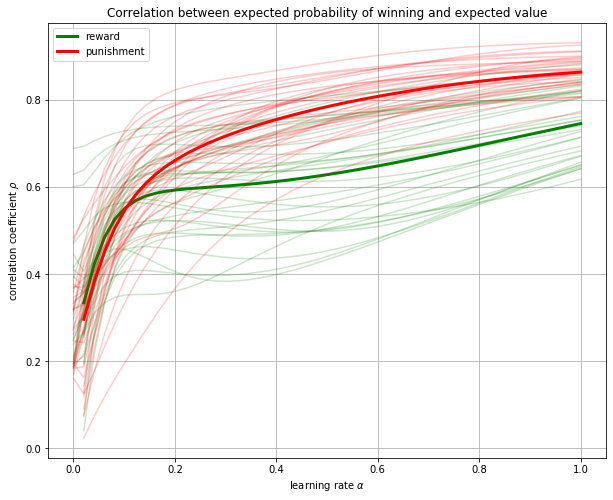

In [3]:
# Define range of parameters
n_gridpoints_alpha = 50 
grid_alpha = np.linspace(0, 1, n_gridpoints_alpha)

corr_wcor_exvl = np.zeros((n_subjects, n_gridpoints_alpha))

fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w', figsize=(10, 8))

for ci, condition in enumerate(['reward', "punishment"]):
    for subject in range(n_subjects):
        
        mask_resp = get_response_mask(beh, meta, subject, ci)
        
        for i, alpha in enumerate(grid_alpha):
            
            # Get model predictions & calculate wcor and exvl
            wbci, util, _ = model1(beh, meta, subject, ci, alpha)
            
            if ci == 0:    
                wcor = np.sum(wbci * mask_resp, axis=1)
            elif ci == 1:  
                wcor = np.sum(1-wbci * mask_resp, axis=1)
            exvl = np.sum(util * wbci * mask_resp, axis=1)

            corr_wcor_exvl[subject, i] = pearsonr(wcor, exvl)[0]

    if condition == "reward":       
        color='g'
    elif condition == "punishment": 
        color='r'
        
    # Plotting 
    for subject in range(n_subjects):
        ax.plot(grid_alpha, corr_wcor_exvl[subject], alpha=.2, color=color)
    
    ax.plot(grid_alpha, np.mean(corr_wcor_exvl, axis=0),
            color=color, linewidth=3, label=condition)
    ax.set_xlabel(r"learning rate $\alpha$")
    ax.set_ylabel(r"correlation coefficient $\rho$")

plt.title("Correlation between expected probability of winning and expected value")  
plt.legend()
plt.grid()
plt.show()

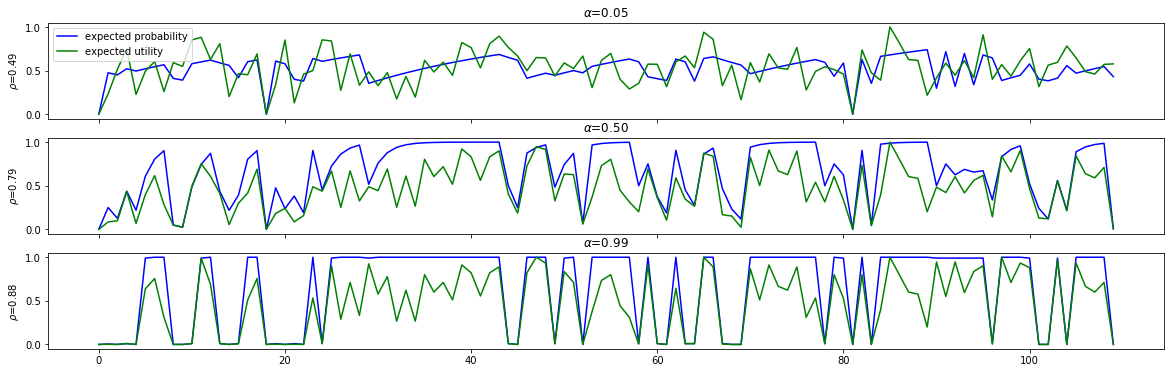

In [4]:
subject = 0
condition = 0

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, facecolor='w', figsize=(20, 6))

for i, alpha in enumerate([.05, .5, .99]):

    wbci, util, _ = model1(beh, meta, subject, condition, alpha)
    mask_resp = get_response_mask(beh, meta, subject, condition)
    
    if condition == 0:    
        wcor = np.sum(wbci * mask_resp, axis=1)
    elif condition == 1:  
        wcor = np.sum(1-wbci * mask_resp, axis=1)
        
    exvl = np.sum(util * wbci * mask_resp, axis=1)
    exvl = exvl / np.max(exvl)

    ax[i].plot(wcor, 'b', label="expected probability")
    ax[i].plot(exvl, 'g', label="expected utility")
    
    rho = pearsonr(wcor, exvl)[0]
    ax[i].set_ylabel(r"$\rho$"+f"={rho:.2f}")
    ax[i].set_title(r"$\alpha$"+f"={alpha:.2f}")
    
ax[0].legend(loc='upper left')
plt.show()

### Explore dual learning rates (simulataneous update)
Is considering two separate learning rates for +PE and -PE **used simultaneously** on each trial sensible in PRL task setting? Here, the effect of this assumption is tested using simple simulations. Plot position on the grid represent fixed values of $\alpha_+$ and $\alpha_-$. Each plot represents change in expected probability of winning after experiencing correct and incorrect choice as a function of initial belief (gray line).

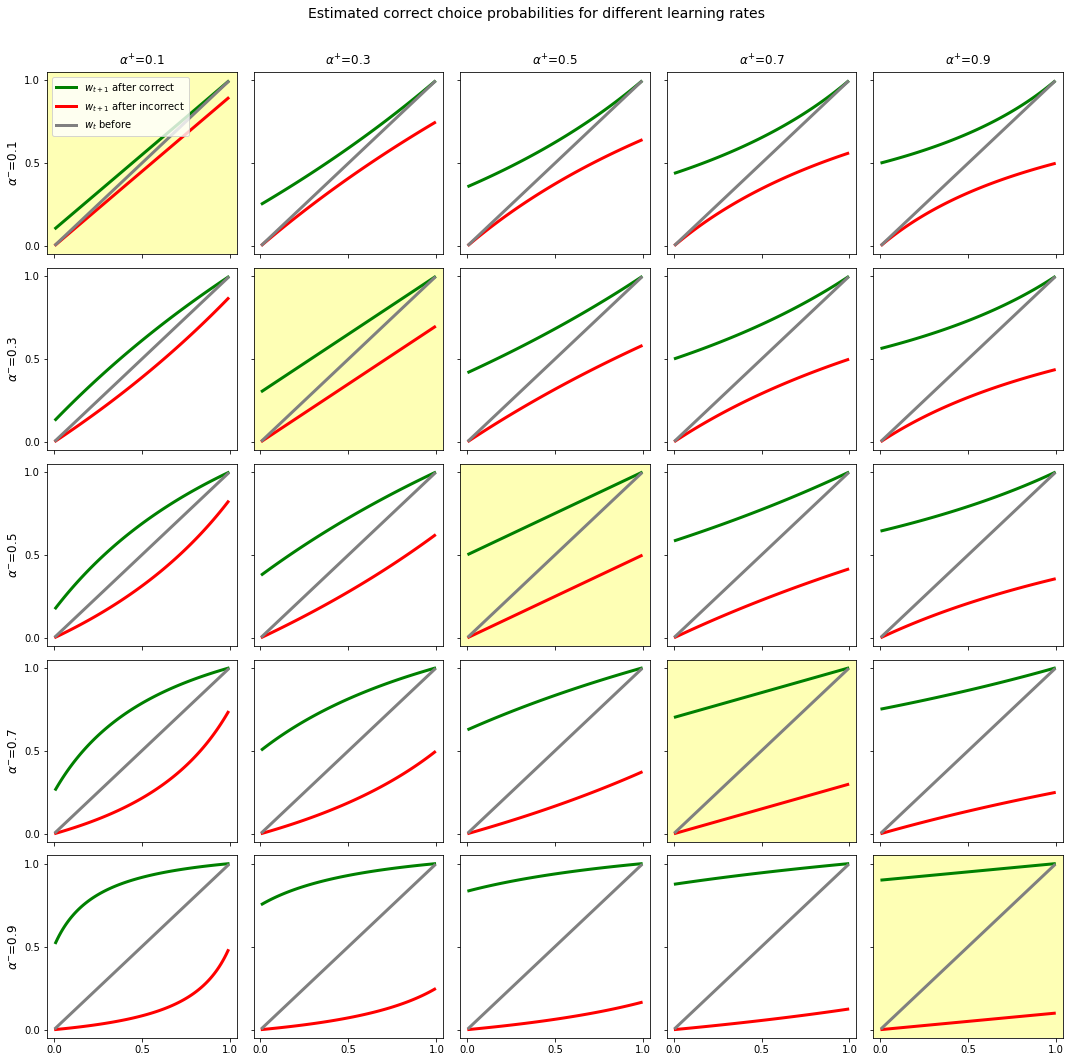

In [5]:
n_gridpoints = 5

lr_plus, lr_minus = np.meshgrid(
    np.linspace(.1, .9, n_gridpoints),
    np.linspace(.1, .9, n_gridpoints)
)

fig, ax = plt.subplots(nrows=n_gridpoints, ncols=n_gridpoints,
                       sharex=True, sharey=True,
                       facecolor='w', figsize=(15, 15))

for i in range(n_gridpoints):
    for j in range(n_gridpoints):

        w_before = np.linspace(0.01, 0.99, 100)
        w_after_cor = np.zeros(w_before.shape)
        w_after_inc = np.zeros(w_before.shape)

        for k, vb in enumerate(w_before):
            
            # Initial probability of second option
            vb_2 = 1 - vb                              
            
            # Correct choice
            vawt = vb + lr_plus[i, j] * (1 - vb)        # Unscaled value after correct choice
            valt_2 = vb_2 + lr_minus[i, j] * (0 - vb_2) # Unscaled value for second option
            w_after_cor[k] = vawt/(vawt+valt_2)         # Scaled value after correct choice
            
            # Incorrect choice
            valt = vb + lr_minus[i, j] * (0 - vb)       # Unscaled value after incorrect choice
            vawt_2 = vb_2 + lr_plus[i, j] * (1 - vb_2)  # Unscaled value for second option
            w_after_inc[k] = valt/(valt+vawt_2)         # Scaled value after incorrect choice

        ax[i, j].plot(w_before, w_after_cor, 'g', linewidth=3, label=r'$w_{t+1}$'+' after correct')
        ax[i, j].plot(w_before, w_after_inc, 'r', linewidth=3, label=r'$w_{t+1}$'+' after incorrect')
        ax[i, j].plot(w_before, w_before, 'grey', linewidth=3, label=r'$w_{t}$'+' before')
        ax[i, j].set_xticks([0, .5, 1])
        ax[i, j].set_yticks([0, .5, 1])
        if i==j:
            ax[i, j].set_facecolor('#feffb5')
        if i == j == 0:
            ax[i, j].legend()
            
cols = [r"$\alpha^{+}$" + f"={lr_plus[1, col]:.1f}" for col in range(5)]
rows = [r"$\alpha^{-}$" + f"={lr_minus[row, 1]:.1f}" for row in range(5)]

for a, col in zip(ax[0], cols):
    a.set_title(col)

for a, row in zip(ax[:,0], rows):
    a.set_ylabel(row, rotation=90, size='large')
    
fig.suptitle('Estimated correct choice probabilities for different learning rates', fontsize=14)
plt.tight_layout()
fig.subplots_adjust(top=0.92)